# UCRB gridded precipitation dataset comparison

Author: Daniel Hogan
Created: September 9, 2023

In this notebook, we will compare gridded annual and seasonal precipitation output for the UCRB and HCDN basins to see how well these all agree.

## Imports

In [2]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import scipy.stats as stats
import datetime as dt

## Pull data

In [3]:
prism_ppt_4km_ds = rxr.open_rasterio('../data/precipdata/prism_4km_ucrb.nc')
# # Load nclimgrid data
nclimgrid_5km_ds = rxr.open_rasterio('../data/precipdata/nclimgrid_5km_ucrb.nc')
# drop the units attribute
del nclimgrid_5km_ds.attrs['units']
# add crs as 4326
nclimgrid_5km_ds.rio.write_crs(4326, inplace=True)
# convert to 32613
nclimgrid_5km_ds = nclimgrid_5km_ds.rio.reproject(32613)
# Load ERA5 data
era5land_9km_ds = rxr.open_rasterio('../data/precipdata/ERA5-land-monthly-1963-2022-UCRB.nc')     
# add crs as 4326
era5land_9km_ds.rio.write_crs(4326, inplace=True)
# convert to 32613
era5land_9km_ds = era5land_9km_ds.rio.reproject(32613)



In [4]:
# for era5 make the crs 4326
ucrb_boundary = gpd.read_file('../data/geodata/Upper_Colorado_River_Basin_Boundary.json')
ucrb_boundary = ucrb_boundary.to_crs(32613)
# clip to ucrb boundary
era5land_9km_ds = era5land_9km_ds.rio.clip(ucrb_boundary.geometry, crs=32613)

In [5]:
# start date for all datasets
start_date = '1963-10-01'
end_date = '2022-09-30'
# for prism rename the variable to prcp
prism_ppt_4km_ds.name = 'prcp'
# rename the month dimension to time
if not 'time' in list(prism_ppt_4km_ds.coords):
    prism_ppt_4km_ds = prism_ppt_4km_ds.rename({'month':'time'})
# for era5 rename the variable to prcp
if not 'prcp' in list(era5land_9km_ds.variables):
    era5land_9km_ds = era5land_9km_ds.rename({'tp':'prcp'})

# clip all data to start and end dates
prism_ppt_4km_ds = prism_ppt_4km_ds.sel(time=slice(start_date,end_date))
nclimgrid_5km_ds = nclimgrid_5km_ds.sel(time=slice(start_date,end_date))
era5land_9km_ds = era5land_9km_ds.sel(time=slice(start_date,end_date))

# fill values below 0 with nan
prism_ppt_4km_ds = prism_ppt_4km_ds.where(prism_ppt_4km_ds >= 0, np.nan)
nclimgrid_5km_ds = nclimgrid_5km_ds.where(nclimgrid_5km_ds >= 0, np.nan)
era5land_9km_ds = era5land_9km_ds.where(era5land_9km_ds >= 0, np.nan)

## Calculate water year means over the UCRB

In [6]:
# get the sum of water year precipitation from october to september for each year
# first add a water year dimension to each dataset
prism_ppt_4km_ds['water_year'] = prism_ppt_4km_ds.time.dt.year.where(prism_ppt_4km_ds.time.dt.month < 10, 
                                                                prism_ppt_4km_ds.time.dt.year+1)
nclimgrid_5km_ds['water_year'] = nclimgrid_5km_ds.time.dt.year.where(nclimgrid_5km_ds.time.dt.month < 10,
                                                                nclimgrid_5km_ds.time.dt.year+1)
era5land_9km_ds['water_year'] = era5land_9km_ds.time.dt.year.where(era5land_9km_ds.time.dt.month < 10,
                                                                era5land_9km_ds.time.dt.year+1)

In [7]:
# group by water year and sum
wy_prism_ppt_4km_ds = prism_ppt_4km_ds.groupby('water_year').sum(dim='time')
wy_nclimgrid_5km_ds = nclimgrid_5km_ds.groupby('water_year').sum(dim='time')
wy_era5land_9km_ds = era5land_9km_ds.groupby('water_year').sum(dim='time')
# fill values that equal 0 with nan
wy_prism_ppt_4km_ds = wy_prism_ppt_4km_ds.where(wy_prism_ppt_4km_ds > 0, np.nan)
wy_nclimgrid_5km_ds = wy_nclimgrid_5km_ds.where(wy_nclimgrid_5km_ds > 0, np.nan)
wy_era5land_9km_ds = wy_era5land_9km_ds.where(wy_era5land_9km_ds > 0, np.nan)
# take the spatial mean of each dataset
wy_mean_prism_ppt_4km_ds = wy_prism_ppt_4km_ds.mean(dim=['x','y'])
wy_mean_nclimgrid_5km_ds = wy_nclimgrid_5km_ds.mean(dim=['x','y'])
wy_mean_era5land_9km_ds = wy_era5land_9km_ds.mean(dim=['x','y'])


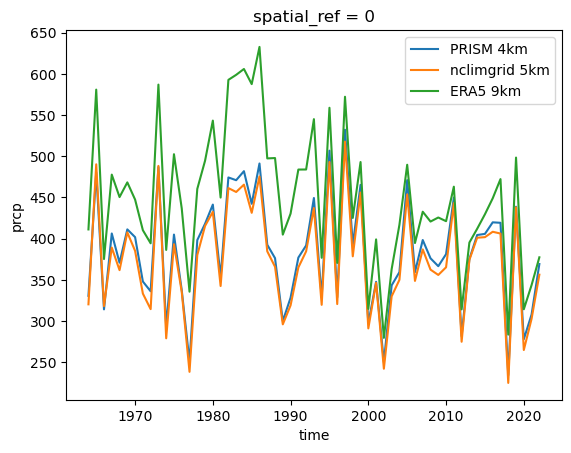

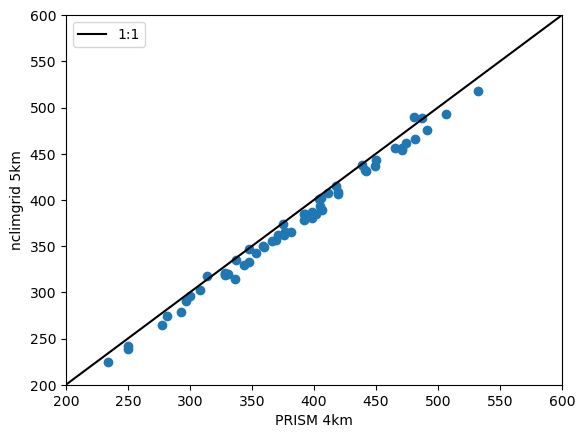

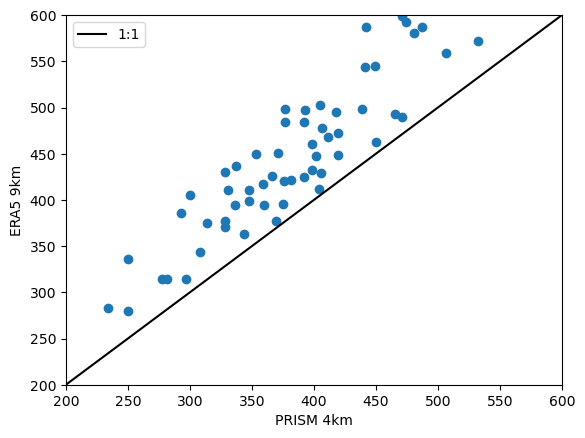

In [8]:
# plot the mean water year precipitation for each dataset
fig, ax = plt.subplots()
wy_mean_prism_ppt_4km_ds.plot(ax=ax, label='PRISM 4km')
wy_mean_nclimgrid_5km_ds.plot(ax=ax, label='nclimgrid 5km')
wy_mean_era5land_9km_ds.prcp.plot(ax=ax, label='ERA5 9km')
ax.legend()
# plot the means against one another and add a 1:1 line
fig, ax = plt.subplots()
ax.scatter(wy_mean_prism_ppt_4km_ds, wy_mean_nclimgrid_5km_ds)
ax.plot([200,600],[200,600], color='k', label='1:1')
ax.set_xlabel('PRISM 4km')
ax.set_ylabel('nclimgrid 5km')
ax.set_xlim([200,600])
ax.set_ylim([200,600])
ax.legend()
fig, ax = plt.subplots()
ax.scatter(wy_mean_prism_ppt_4km_ds, wy_mean_era5land_9km_ds.prcp)
ax.plot([200,600],[200,600], color='k', label='1:1')
ax.set_xlabel('PRISM 4km')
ax.set_ylabel('ERA5 9km')
ax.set_xlim([200,600])
ax.set_ylim([200,600])
ax.legend()

## Calculate Seasonal averages for each 

In [9]:
# calculate the seasonal sum of precipitation for each dataset october to december, january to march, april to june, july to september
prism_fall_ppt_4km_ds = prism_ppt_4km_ds.where(prism_ppt_4km_ds.time.dt.month.isin([10,11,12]), drop=True).mean(dim=['x','y'])
prism_winter_ppt_4km_ds = prism_ppt_4km_ds.where(prism_ppt_4km_ds.time.dt.month.isin([1,2,3]), drop=True).mean(dim=['x','y'])
prism_spring_ppt_4km_ds = prism_ppt_4km_ds.where(prism_ppt_4km_ds.time.dt.month.isin([4,5,6]), drop=True).mean(dim=['x','y'])
prism_summer_ppt_4km_ds = prism_ppt_4km_ds.where(prism_ppt_4km_ds.time.dt.month.isin([7,8,9]), drop=True).mean(dim=['x','y'])

nclimgrid_fall_ppt_5km_ds = nclimgrid_5km_ds.where(nclimgrid_5km_ds.time.dt.month.isin([10,11,12]), drop=True).mean(dim=['x','y'])
nclimgrid_winter_ppt_5km_ds = nclimgrid_5km_ds.where(nclimgrid_5km_ds.time.dt.month.isin([1,2,3]), drop=True).mean(dim=['x','y'])
nclimgrid_spring_ppt_5km_ds = nclimgrid_5km_ds.where(nclimgrid_5km_ds.time.dt.month.isin([4,5,6]), drop=True).mean(dim=['x','y'])
nclimgrid_summer_ppt_5km_ds = nclimgrid_5km_ds.where(nclimgrid_5km_ds.time.dt.month.isin([7,8,9]), drop=True).mean(dim=['x','y'])

era5land_fall_ppt_9km_ds = era5land_9km_ds.where(era5land_9km_ds.time.dt.month.isin([10,11,12]), drop=True).mean(dim=['x','y'])
era5land_winter_ppt_9km_ds = era5land_9km_ds.where(era5land_9km_ds.time.dt.month.isin([1,2,3]), drop=True).mean(dim=['x','y'])
era5land_spring_ppt_9km_ds = era5land_9km_ds.where(era5land_9km_ds.time.dt.month.isin([4,5,6]), drop=True).mean(dim=['x','y'])
era5land_summer_ppt_9km_ds = era5land_9km_ds.where(era5land_9km_ds.time.dt.month.isin([7,8,9]), drop=True).mean(dim=['x','y'])

Text(0.06, 0.5, 'nclimgrid 5km')

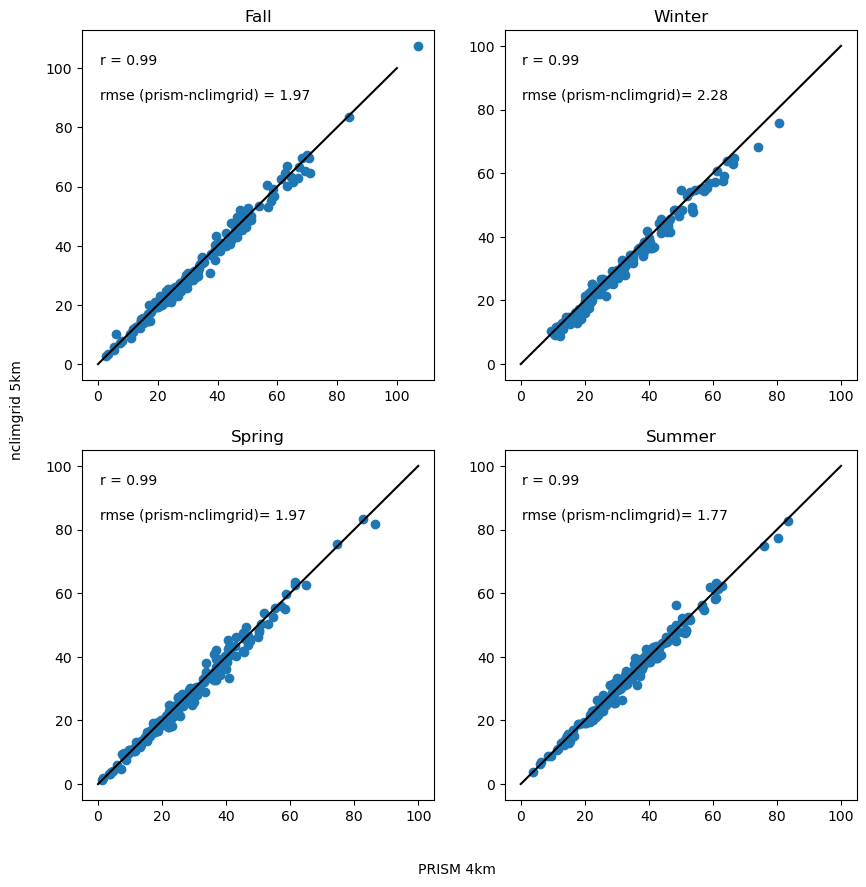

In [10]:
# create a 2x2 plot of the seasonal precipitation
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].scatter(prism_fall_ppt_4km_ds, nclimgrid_fall_ppt_5km_ds)
ax[0,1].scatter(prism_winter_ppt_4km_ds, nclimgrid_winter_ppt_5km_ds)
ax[1,0].scatter(prism_spring_ppt_4km_ds, nclimgrid_spring_ppt_5km_ds)
ax[1,1].scatter(prism_summer_ppt_4km_ds, nclimgrid_summer_ppt_5km_ds)
# add correlation coefficients as text to each plot
ax[0,0].text(0.05,0.9,'r = ' + str(np.round(np.corrcoef(prism_fall_ppt_4km_ds, nclimgrid_fall_ppt_5km_ds)[0,1],2)), transform=ax[0,0].transAxes)
ax[0,1].text(0.05,0.9,'r = ' + str(np.round(np.corrcoef(prism_winter_ppt_4km_ds, nclimgrid_winter_ppt_5km_ds)[0,1],2)), transform=ax[0,1].transAxes)
ax[1,0].text(0.05,0.9,'r = ' + str(np.round(np.corrcoef(prism_spring_ppt_4km_ds, nclimgrid_spring_ppt_5km_ds)[0,1],2)), transform=ax[1,0].transAxes)
ax[1,1].text(0.05,0.9,'r = ' + str(np.round(np.corrcoef(prism_summer_ppt_4km_ds, nclimgrid_summer_ppt_5km_ds)[0,1],2)), transform=ax[1,1].transAxes)
# add the rmse as text to each plot
ax[0,0].text(0.05,0.8,'rmse (prism-nclimgrid) = ' + str(np.round(np.sqrt(np.mean((prism_fall_ppt_4km_ds.values - nclimgrid_fall_ppt_5km_ds.values)**2)),2)), transform=ax[0,0].transAxes)
ax[0,1].text(0.05,0.8,'rmse (prism-nclimgrid)= ' + str(np.round(np.sqrt(np.mean((prism_winter_ppt_4km_ds.values - nclimgrid_winter_ppt_5km_ds.values)**2)),2)), transform=ax[0,1].transAxes)
ax[1,0].text(0.05,0.8,'rmse (prism-nclimgrid)= ' + str(np.round(np.sqrt(np.mean((prism_spring_ppt_4km_ds.values - nclimgrid_spring_ppt_5km_ds.values)**2)),2)), transform=ax[1,0].transAxes)
ax[1,1].text(0.05,0.8,'rmse (prism-nclimgrid)= ' + str(np.round(np.sqrt(np.mean((prism_summer_ppt_4km_ds.values - nclimgrid_summer_ppt_5km_ds.values)**2)),2)), transform=ax[1,1].transAxes)
# add 1:1 lines
ax[0,0].plot([0,100],[0,100], color='k', label='1:1')
ax[0,1].plot([0,100],[0,100], color='k', label='1:1')
ax[1,0].plot([0,100],[0,100], color='k', label='1:1')
ax[1,1].plot([0,100],[0,100], color='k', label='1:1')
ax[0,0].set_title('Fall')
ax[0,1].set_title('Winter')
ax[1,0].set_title('Spring')   
ax[1,1].set_title('Summer')
# add x and y labels for the figure
fig.text(0.5, 0.04, 'PRISM 4km', ha='center', va='center')
fig.text(0.06, 0.5, 'nclimgrid 5km', ha='center', va='center', rotation='vertical')


Text(0.06, 0.5, 'era5land 9km')

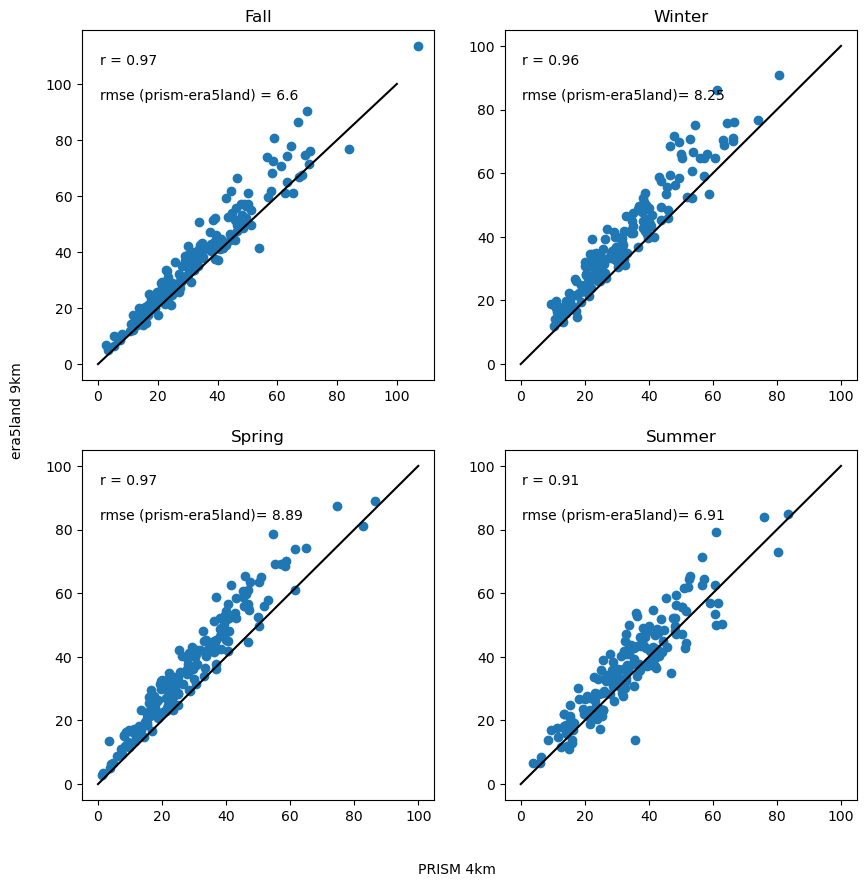

In [11]:
# create a 2x2 plot of the seasonal precipitation
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].scatter(prism_fall_ppt_4km_ds, era5land_fall_ppt_9km_ds.prcp)
ax[0,1].scatter(prism_winter_ppt_4km_ds, era5land_winter_ppt_9km_ds.prcp)
ax[1,0].scatter(prism_spring_ppt_4km_ds, era5land_spring_ppt_9km_ds.prcp)
ax[1,1].scatter(prism_summer_ppt_4km_ds, era5land_summer_ppt_9km_ds.prcp)
# add correlation coefficients as text to each plot
ax[0,0].text(0.05,0.9,'r = ' + str(np.round(np.corrcoef(prism_fall_ppt_4km_ds, era5land_fall_ppt_9km_ds.prcp)[0,1],2)), transform=ax[0,0].transAxes)
ax[0,1].text(0.05,0.9,'r = ' + str(np.round(np.corrcoef(prism_winter_ppt_4km_ds, era5land_winter_ppt_9km_ds.prcp)[0,1],2)), transform=ax[0,1].transAxes)
ax[1,0].text(0.05,0.9,'r = ' + str(np.round(np.corrcoef(prism_spring_ppt_4km_ds, era5land_spring_ppt_9km_ds.prcp)[0,1],2)), transform=ax[1,0].transAxes)
ax[1,1].text(0.05,0.9,'r = ' + str(np.round(np.corrcoef(prism_summer_ppt_4km_ds, era5land_summer_ppt_9km_ds.prcp)[0,1],2)), transform=ax[1,1].transAxes)
# add the rmse as text to each plot
ax[0,0].text(0.05,0.8,'rmse (prism-era5land) = ' + str(np.round(np.sqrt(np.mean((prism_fall_ppt_4km_ds.values - era5land_fall_ppt_9km_ds.prcp.values)**2)),2)), transform=ax[0,0].transAxes)
ax[0,1].text(0.05,0.8,'rmse (prism-era5land)= ' + str(np.round(np.sqrt(np.mean((prism_winter_ppt_4km_ds.values - era5land_winter_ppt_9km_ds.prcp.values)**2)),2)), transform=ax[0,1].transAxes)
ax[1,0].text(0.05,0.8,'rmse (prism-era5land)= ' + str(np.round(np.sqrt(np.mean((prism_spring_ppt_4km_ds.values - era5land_spring_ppt_9km_ds.prcp.values)**2)),2)), transform=ax[1,0].transAxes)
ax[1,1].text(0.05,0.8,'rmse (prism-era5land)= ' + str(np.round(np.sqrt(np.mean((prism_summer_ppt_4km_ds.values - era5land_summer_ppt_9km_ds.prcp.values)**2)),2)), transform=ax[1,1].transAxes)
# add 1:1 lines
ax[0,0].plot([0,100],[0,100], color='k', label='1:1')
ax[0,1].plot([0,100],[0,100], color='k', label='1:1')
ax[1,0].plot([0,100],[0,100], color='k', label='1:1')
ax[1,1].plot([0,100],[0,100], color='k', label='1:1')
ax[0,0].set_title('Fall')
ax[0,1].set_title('Winter')
ax[1,0].set_title('Spring')   
ax[1,1].set_title('Summer')
# add x and y labels for the figure
fig.text(0.5, 0.04, 'PRISM 4km', ha='center', va='center')
fig.text(0.06, 0.5, 'era5land 9km', ha='center', va='center', rotation='vertical')


In [12]:
# calculate the mean seasonal precipitation for each dataset october to december, january to march, april to june, july to september
# spring
pre_2000_spring_prism_ds = prism_ppt_4km_ds.where((prism_ppt_4km_ds.time.dt.year < 2000) & (prism_ppt_4km_ds.time.dt.month.isin([4,5,6])), drop=True).mean(dim='time')
pre_2000_spring_nclimgrid_ds = nclimgrid_5km_ds.where((nclimgrid_5km_ds.time.dt.year < 2000) & (nclimgrid_5km_ds.time.dt.month.isin([4,5,6])), drop=True).mean(dim='time')
pre_2000_spring_era5land_ds = era5land_9km_ds.where((era5land_9km_ds.time.dt.year < 2000) & (era5land_9km_ds.time.dt.month.isin([4,5,6])), drop=True).mean(dim='time').prcp
post_2000_spring_prism_ds = prism_ppt_4km_ds.where((prism_ppt_4km_ds.time.dt.year >= 2000) & (prism_ppt_4km_ds.time.dt.month.isin([4,5,6])), drop=True).mean(dim='time')
post_2000_spring_nclimgrid_ds = nclimgrid_5km_ds.where((nclimgrid_5km_ds.time.dt.year >= 2000) & (nclimgrid_5km_ds.time.dt.month.isin([4,5,6])), drop=True).mean(dim='time')
post_2000_spring_era5land_ds = era5land_9km_ds.where((era5land_9km_ds.time.dt.year >= 2000) & (era5land_9km_ds.time.dt.month.isin([4,5,6])), drop=True).mean(dim='time').prcp

# summer
pre_2000_summer_prism_ds = prism_ppt_4km_ds.where((prism_ppt_4km_ds.time.dt.year < 2000) & (prism_ppt_4km_ds.time.dt.month.isin([7,8,9])), drop=True).mean(dim='time')
pre_2000_summer_nclimgrid_ds = nclimgrid_5km_ds.where((nclimgrid_5km_ds.time.dt.year < 2000) & (nclimgrid_5km_ds.time.dt.month.isin([7,8,9])), drop=True).mean(dim='time')
pre_2000_summer_era5land_ds = era5land_9km_ds.where((era5land_9km_ds.time.dt.year < 2000) & (era5land_9km_ds.time.dt.month.isin([7,8,9])), drop=True).mean(dim='time').prcp
post_2000_summer_prism_ds = prism_ppt_4km_ds.where((prism_ppt_4km_ds.time.dt.year >= 2000) & (prism_ppt_4km_ds.time.dt.month.isin([7,8,9])), drop=True).mean(dim='time')
post_2000_summer_nclimgrid_ds = nclimgrid_5km_ds.where((nclimgrid_5km_ds.time.dt.year >= 2000) & (nclimgrid_5km_ds.time.dt.month.isin([7,8,9])), drop=True).mean(dim='time')
post_2000_summer_era5land_ds = era5land_9km_ds.where((era5land_9km_ds.time.dt.year >= 2000) & (era5land_9km_ds.time.dt.month.isin([7,8,9])), drop=True).mean(dim='time').prcp
# fall
pre_2000_fall_prism_ds = prism_ppt_4km_ds.where((prism_ppt_4km_ds.time.dt.year < 2000) & (prism_ppt_4km_ds.time.dt.month.isin([10,11,12])), drop=True).mean(dim='time')
pre_2000_fall_nclimgrid_ds = nclimgrid_5km_ds.where((nclimgrid_5km_ds.time.dt.year < 2000) & (nclimgrid_5km_ds.time.dt.month.isin([10,11,12])), drop=True).mean(dim='time')
pre_2000_fall_era5land_ds = era5land_9km_ds.where((era5land_9km_ds.time.dt.year < 2000) & (era5land_9km_ds.time.dt.month.isin([10,11,12])), drop=True).mean(dim='time').prcp
post_2000_fall_prism_ds = prism_ppt_4km_ds.where((prism_ppt_4km_ds.time.dt.year >= 2000) & (prism_ppt_4km_ds.time.dt.month.isin([10,11,12])), drop=True).mean(dim='time')
post_2000_fall_nclimgrid_ds = nclimgrid_5km_ds.where((nclimgrid_5km_ds.time.dt.year >= 2000) & (nclimgrid_5km_ds.time.dt.month.isin([10,11,12])), drop=True).mean(dim='time')
post_2000_fall_era5land_ds = era5land_9km_ds.where((era5land_9km_ds.time.dt.year >= 2000) & (era5land_9km_ds.time.dt.month.isin([10,11,12])), drop=True).mean(dim='time').prcp
# winter
pre_2000_winter_prism_ds = prism_ppt_4km_ds.where((prism_ppt_4km_ds.time.dt.year < 2000) & (prism_ppt_4km_ds.time.dt.month.isin([1,2,3])), drop=True).mean(dim='time')
pre_2000_winter_nclimgrid_ds = nclimgrid_5km_ds.where((nclimgrid_5km_ds.time.dt.year < 2000) & (nclimgrid_5km_ds.time.dt.month.isin([1,2,3])), drop=True).mean(dim='time')
pre_2000_winter_era5land_ds = era5land_9km_ds.where((era5land_9km_ds.time.dt.year < 2000) & (era5land_9km_ds.time.dt.month.isin([1,2,3])), drop=True).mean(dim='time').prcp
post_2000_winter_prism_ds = prism_ppt_4km_ds.where((prism_ppt_4km_ds.time.dt.year >= 2000) & (prism_ppt_4km_ds.time.dt.month.isin([1,2,3])), drop=True).mean(dim='time')
post_2000_winter_nclimgrid_ds = nclimgrid_5km_ds.where((nclimgrid_5km_ds.time.dt.year >= 2000) & (nclimgrid_5km_ds.time.dt.month.isin([1,2,3])), drop=True).mean(dim='time')
post_2000_winter_era5land_ds = era5land_9km_ds.where((era5land_9km_ds.time.dt.year >= 2000) & (era5land_9km_ds.time.dt.month.isin([1,2,3])), drop=True).mean(dim='time').prcp

Text(0.5, 0.98, 'Mean Spring Precipitation Difference between 2000-2022 and 1964-1999')

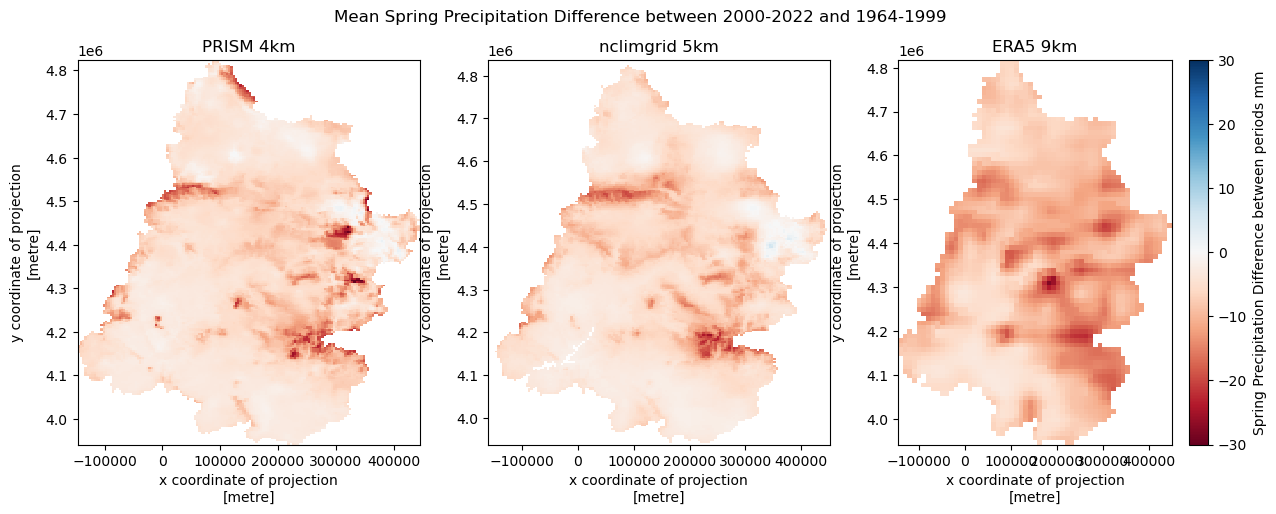

In [13]:
# plot 2 spatial maps of spring precipitation differences between periods
fig, ax = plt.subplots(1,3, figsize=(15,5))
# plot prism difference
(post_2000_spring_prism_ds - pre_2000_spring_prism_ds).plot(ax=ax[0], vmin=-30, vmax=30, cmap='RdBu', add_colorbar=False)
# plot nclimgrid difference
(post_2000_spring_nclimgrid_ds - pre_2000_spring_nclimgrid_ds).plot(ax=ax[1],vmin=-30, vmax=30, cmap='RdBu', add_colorbar=False)
# plot era5land difference
(post_2000_spring_era5land_ds - pre_2000_spring_era5land_ds).plot(ax=ax[2],vmin=-30, vmax=30, cmap='RdBu', add_colorbar=False)
# add titles
ax[0].set_title('PRISM 4km')
ax[1].set_title('nclimgrid 5km')
ax[2].set_title('ERA5 9km')
# add colorbars
fig.colorbar(ax[2].collections[0], ax=ax[2], label='Spring Precipitation Difference between periods mm')
fig.suptitle('Mean Spring Precipitation Difference between 2000-2022 and 1964-1999')


Text(0.5, 0.98, 'Mean winter Precipitation Difference between 2000-2022 and 1964-1999')

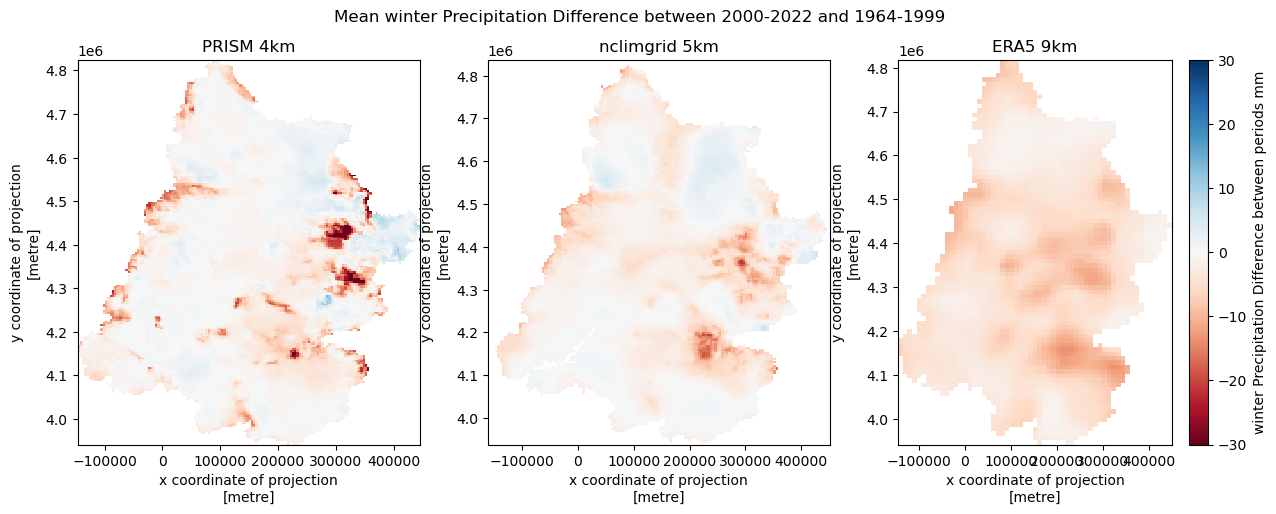

In [14]:
# plot 2 spatial maps of winter precipitation differences between periods
fig, ax = plt.subplots(1,3, figsize=(15,5))
# plot prism difference
(post_2000_winter_prism_ds - pre_2000_winter_prism_ds).plot(ax=ax[0], vmin=-30, vmax=30, cmap='RdBu', add_colorbar=False)
# plot nclimgrid difference
(post_2000_winter_nclimgrid_ds - pre_2000_winter_nclimgrid_ds).plot(ax=ax[1],vmin=-30, vmax=30, cmap='RdBu', add_colorbar=False)
# plot era5land difference
(post_2000_winter_era5land_ds - pre_2000_winter_era5land_ds).plot(ax=ax[2],vmin=-30, vmax=30, cmap='RdBu', add_colorbar=False)
# add titles
ax[0].set_title('PRISM 4km')
ax[1].set_title('nclimgrid 5km')
ax[2].set_title('ERA5 9km')
# add colorbars
fig.colorbar(ax[2].collections[0], ax=ax[2], label='winter Precipitation Difference between periods mm')
fig.suptitle('Mean winter Precipitation Difference between 2000-2022 and 1964-1999')


Text(0.5, 0.98, 'Mean fall Precipitation Difference between 2000-2022 and 1964-1999')

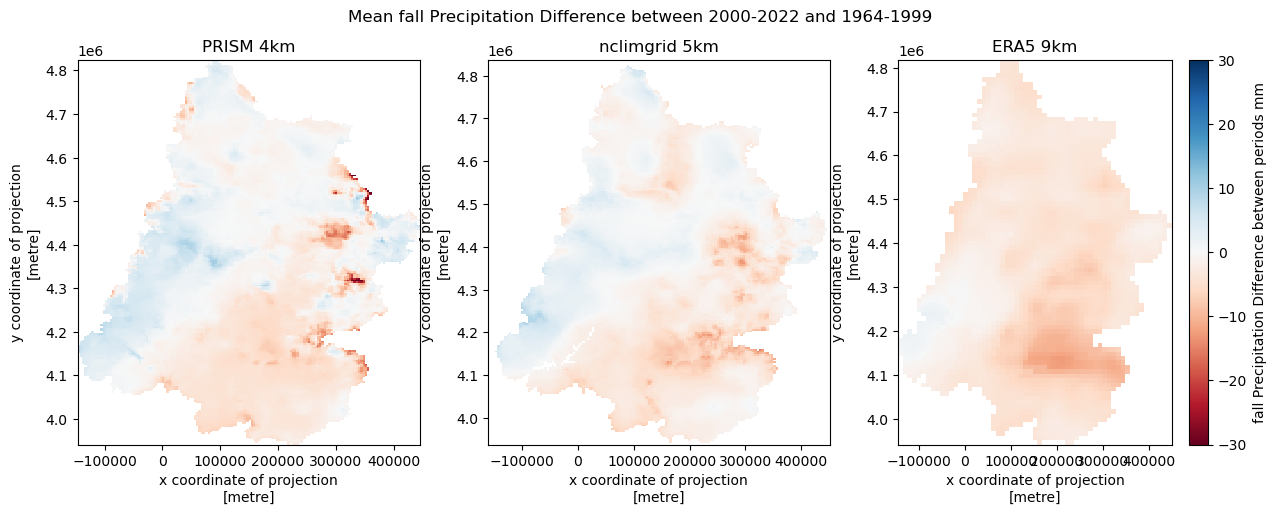

In [15]:
# plot 2 spatial maps of fall precipitation differences between periods
fig, ax = plt.subplots(1,3, figsize=(15,5))
# plot prism difference
(post_2000_fall_prism_ds - pre_2000_fall_prism_ds).plot(ax=ax[0], vmin=-30, vmax=30, cmap='RdBu', add_colorbar=False)
# plot nclimgrid difference
(post_2000_fall_nclimgrid_ds - pre_2000_fall_nclimgrid_ds).plot(ax=ax[1],vmin=-30, vmax=30, cmap='RdBu', add_colorbar=False)
# plot era5land difference
(post_2000_fall_era5land_ds - pre_2000_fall_era5land_ds).plot(ax=ax[2],vmin=-30, vmax=30, cmap='RdBu', add_colorbar=False)
# add titles
ax[0].set_title('PRISM 4km')
ax[1].set_title('nclimgrid 5km')
ax[2].set_title('ERA5 9km')
# add colorbars
fig.colorbar(ax[2].collections[0], ax=ax[2], label='fall Precipitation Difference between periods mm')
fig.suptitle('Mean fall Precipitation Difference between 2000-2022 and 1964-1999')


Text(0.5, 0.98, 'Mean summer Precipitation Difference between 2000-2022 and 1964-1999')

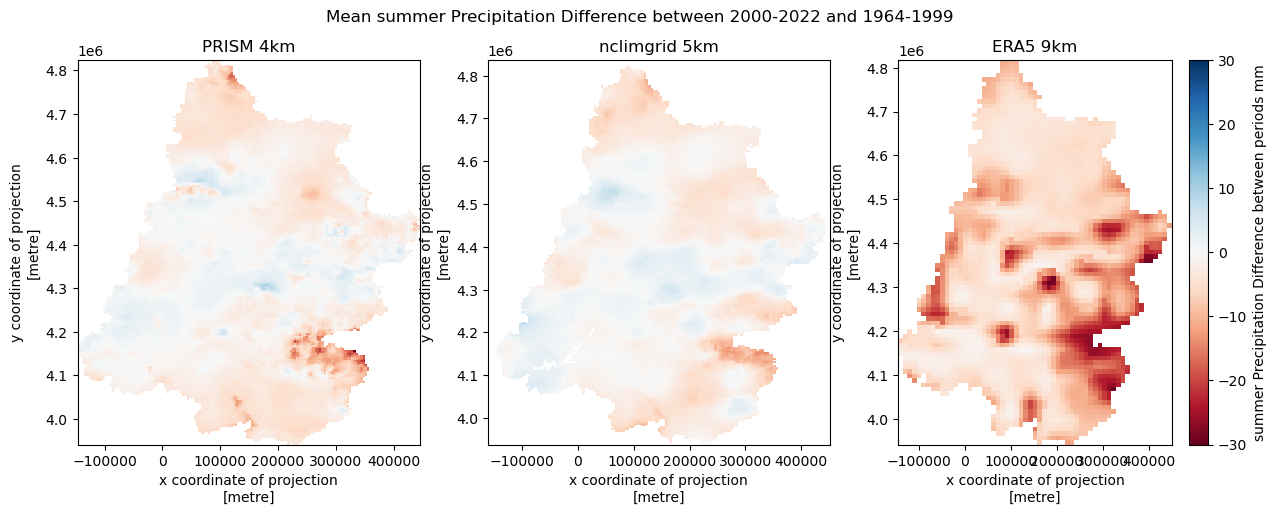

In [16]:
# plot 2 spatial maps of summer precipitation differences between periods
fig, ax = plt.subplots(1,3, figsize=(15,5))
# plot prism difference
(post_2000_summer_prism_ds - pre_2000_summer_prism_ds).plot(ax=ax[0], vmin=-30, vmax=30, cmap='RdBu', add_colorbar=False)
# plot nclimgrid difference
(post_2000_summer_nclimgrid_ds - pre_2000_summer_nclimgrid_ds).plot(ax=ax[1],vmin=-30, vmax=30, cmap='RdBu', add_colorbar=False)
# plot era5land difference
(post_2000_summer_era5land_ds - pre_2000_summer_era5land_ds).plot(ax=ax[2],vmin=-30, vmax=30, cmap='RdBu', add_colorbar=False)
# add titles
ax[0].set_title('PRISM 4km')
ax[1].set_title('nclimgrid 5km')
ax[2].set_title('ERA5 9km')
# add colorbars
fig.colorbar(ax[2].collections[0], ax=ax[2], label='summer Precipitation Difference between periods mm')
fig.suptitle('Mean summer Precipitation Difference between 2000-2022 and 1964-1999')


### Now, lets work with HCDN basin averages, and the differences between seasons for each

In [30]:
# load in hcdn basins
hcdn_basins = gpd.read_file('../data/geodata/basin_station_sntl.json', driver='GeoJSON')
# convert to 4326
hcdn_basins = hcdn_basins.to_crs(32613)
# on the seasonal pre and post maps, iterate through and find the basin averages
# create a dictionary to store the basin averages
spring_mean_difference = {}
spring_std_difference = {}
for gage in hcdn_basins.gage:
    basin = hcdn_basins[hcdn_basins.gage == gage]
    try:
        prism_tmp = (post_2000_spring_prism_ds - pre_2000_spring_prism_ds).where(post_2000_spring_prism_ds.rio.clip(basin.geometry), drop=True)
    except:
        # grab the nearest grid cell to the centroid of the basin
        prism_tmp = (post_2000_spring_prism_ds - pre_2000_spring_prism_ds).sel(x=basin.geometry.centroid.x.values, y=basin.geometry.centroid.y.values, method='nearest')
    try:
        nclimgrid_tmp = (post_2000_spring_nclimgrid_ds - pre_2000_spring_nclimgrid_ds).rio.clip(basin.geometry)
    except:
        # grab the nearest grid cell to the centroid of the basin using interp
        nclimgrid_tmp = (post_2000_spring_nclimgrid_ds - pre_2000_spring_nclimgrid_ds).rio.clip(basin.geometry, crs=32613, all_touched=True)
    try:
        era5land_tmp = (post_2000_spring_era5land_ds - pre_2000_spring_era5land_ds).rio.clip(basin.geometry)
    except:
        # grab the nearest grid cell to the centroid of the basin using interp
        era5land_tmp = (post_2000_spring_era5land_ds - pre_2000_spring_era5land_ds).rio.clip(basin.geometry, crs=32613, all_touched=True)

    # get the mean spring precipitation for the basin
    spring_mean_difference[gage] = {'prism':prism_tmp.mean(dim=['x','y']).values,
                               'nclimgrid':nclimgrid_tmp.mean(dim=['x','y']).values,
                               'era5land':era5land_tmp.mean(dim=['x','y']).values}
    spring_std_difference[gage] = {'prism':prism_tmp.std(dim=['x','y']).values,
                                   'nclimgrid':nclimgrid_tmp.std(dim=['x','y']).values,
                                   'era5land':era5land_tmp.std(dim=['x','y']).values}

/home/dlhogan/miniforge3/envs/ucrb_analysis_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [31]:
winter_mean_difference = {}
winter_std_difference = {}
for gage in hcdn_basins.gage:
    basin = hcdn_basins[hcdn_basins.gage == gage]
    try:
        prism_tmp = (post_2000_winter_prism_ds - pre_2000_winter_prism_ds).where(post_2000_winter_prism_ds.rio.clip(basin.geometry), drop=True)
    except:
        # grab the nearest grid cell to the centroid of the basin
        prism_tmp = (post_2000_winter_prism_ds - pre_2000_winter_prism_ds).sel(x=basin.geometry.centroid.x.values, y=basin.geometry.centroid.y.values, method='nearest')
    try:
        nclimgrid_tmp = (post_2000_winter_nclimgrid_ds - pre_2000_winter_nclimgrid_ds).rio.clip(basin.geometry)
    except:
        # grab the nearest grid cell to the centroid of the basin using interp
        nclimgrid_tmp = (post_2000_winter_nclimgrid_ds - pre_2000_winter_nclimgrid_ds).rio.clip(basin.geometry, crs=32613, all_touched=True)
    try:
        era5land_tmp = (post_2000_winter_era5land_ds - pre_2000_winter_era5land_ds).rio.clip(basin.geometry)
    except:
        # grab the nearest grid cell to the centroid of the basin using interp
        era5land_tmp = (post_2000_winter_era5land_ds - pre_2000_winter_era5land_ds).rio.clip(basin.geometry, crs=32613, all_touched=True)

    # get the mean winter precipitation for the basin
    winter_mean_difference[gage] = {'prism':prism_tmp.mean(dim=['x','y']).values,
                               'nclimgrid':nclimgrid_tmp.mean(dim=['x','y']).values,
                               'era5land':era5land_tmp.mean(dim=['x','y']).values}
    winter_std_difference[gage] = {'prism':prism_tmp.std(dim=['x','y']).values,
                                   'nclimgrid':nclimgrid_tmp.std(dim=['x','y']).values,
                                   'era5land':era5land_tmp.std(dim=['x','y']).values}

/home/dlhogan/miniforge3/envs/ucrb_analysis_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


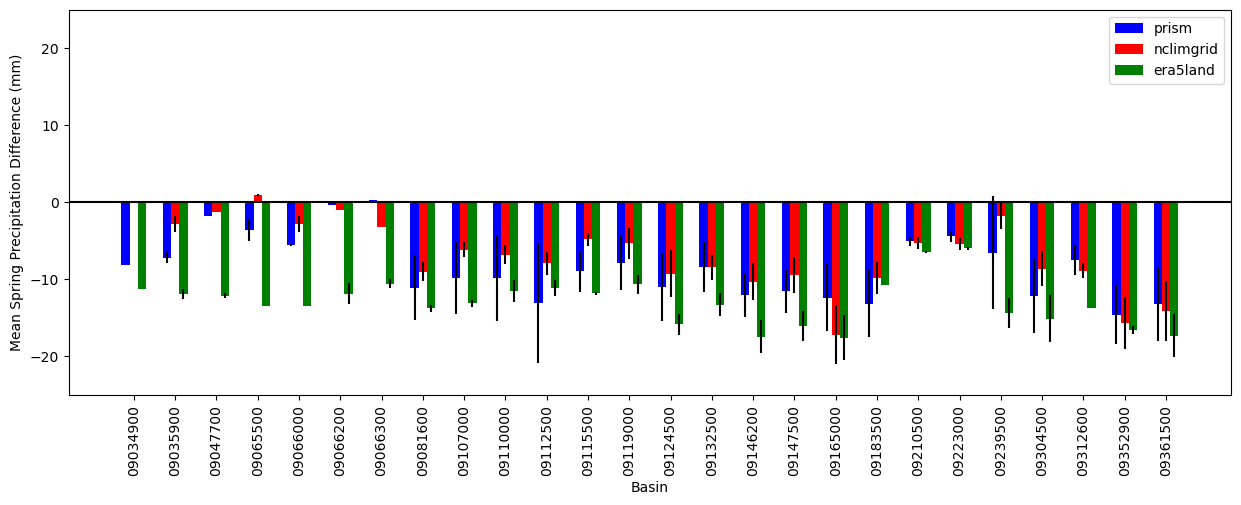

In [39]:
# convert the dictionary to a dataframe
spring_mean_difference_df = pd.DataFrame.from_dict(spring_mean_difference, orient='index', dtype=np.float64)
spring_std_difference_df = pd.DataFrame.from_dict(spring_std_difference, orient='index', dtype=np.float64)

# plot a grouped bar plot of the mean spring precipitation difference for each basin with error bars with the standard deviation
fig, ax = plt.subplots(figsize=(15,5))

for i, gage in enumerate(spring_mean_difference_df.index):
    if i == 0:
        ax.bar(i-0.2, 
               spring_mean_difference_df.loc[gage,'prism'], 
               width=0.2, 
               yerr=spring_std_difference_df.loc[gage,'prism'], 
               label='prism',
               color='blue')
        ax.bar(i, 
               spring_mean_difference_df.loc[gage,'nclimgrid'], 
               width=0.2, 
               yerr=spring_std_difference_df.loc[gage,'nclimgrid'], 
               label='nclimgrid',
               color='red')
        ax.bar(i+0.2,
                spring_mean_difference_df.loc[gage,'era5land'], 
                width=0.2, 
                yerr=spring_std_difference_df.loc[gage,'era5land'], 
                label='era5land',
                color='green')
        ax.legend()
    else:
        ax.bar(i-0.2, 
               spring_mean_difference_df.loc[gage,'prism'], 
               width=0.2, 
               yerr=spring_std_difference_df.loc[gage,'prism'], 
               color='blue')
        ax.bar(i,
                spring_mean_difference_df.loc[gage,'nclimgrid'], 
                width=0.2, 
                yerr=spring_std_difference_df.loc[gage,'nclimgrid'], 
                color='red')
        ax.bar(i+0.2,
                spring_mean_difference_df.loc[gage,'era5land'], 
                width=0.2, 
                yerr=spring_std_difference_df.loc[gage,'era5land'], 
                color='green')
# add a horizontal line at 0
ax.axhline(0, color='k')
ax.set_ylabel('Mean Spring Precipitation Difference (mm)')
ax.set_xlabel('Basin')
ax.set_ylim(-25,25)
# set the xticks to the basin names
ax.set_xticks(np.arange(len(spring_mean_difference_df.index)), spring_mean_difference_df.index, rotation=90);


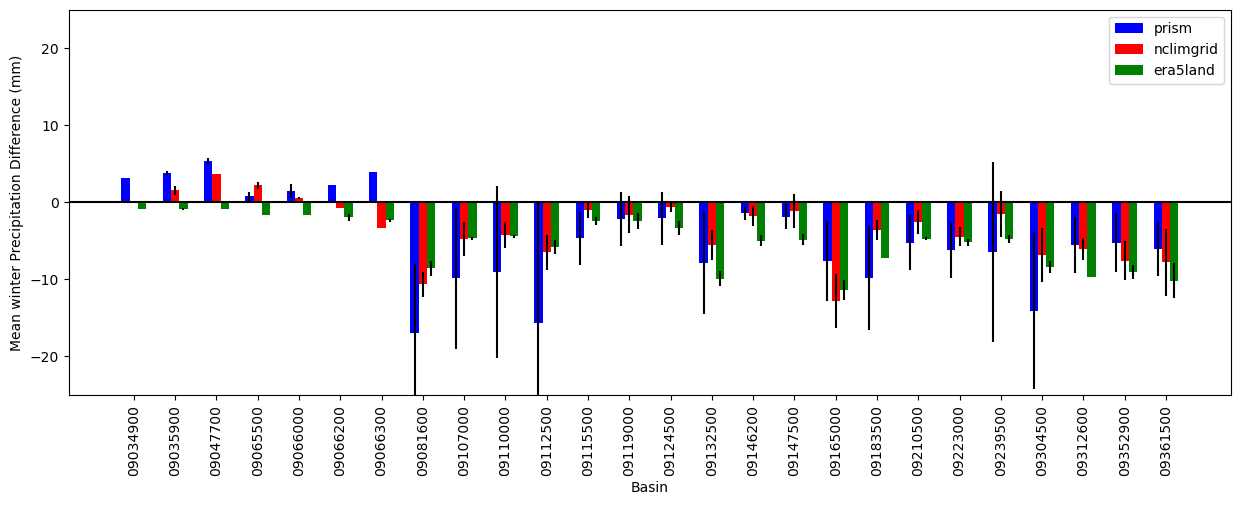

In [40]:
# convert the dictionary to a dataframe
winter_mean_difference_df = pd.DataFrame.from_dict(winter_mean_difference, orient='index', dtype=np.float64)
winter_std_difference_df = pd.DataFrame.from_dict(winter_std_difference, orient='index', dtype=np.float64)

# plot a grouped bar plot of the mean winter precipitation difference for each basin with error bars with the standard deviation
fig, ax = plt.subplots(figsize=(15,5))

for i, gage in enumerate(winter_mean_difference_df.index):
    if i == 0:
        ax.bar(i-0.2, 
               winter_mean_difference_df.loc[gage,'prism'], 
               width=0.2, 
               yerr=winter_std_difference_df.loc[gage,'prism'], 
               label='prism',
               color='blue')
        ax.bar(i, 
               winter_mean_difference_df.loc[gage,'nclimgrid'], 
               width=0.2, 
               yerr=winter_std_difference_df.loc[gage,'nclimgrid'], 
               label='nclimgrid',
               color='red')
        ax.bar(i+0.2,
                winter_mean_difference_df.loc[gage,'era5land'], 
                width=0.2, 
                yerr=winter_std_difference_df.loc[gage,'era5land'], 
                label='era5land',
                color='green')
        ax.legend()
    else:
        ax.bar(i-0.2, 
               winter_mean_difference_df.loc[gage,'prism'], 
               width=0.2, 
               yerr=winter_std_difference_df.loc[gage,'prism'], 
               color='blue')
        ax.bar(i,
                winter_mean_difference_df.loc[gage,'nclimgrid'], 
                width=0.2, 
                yerr=winter_std_difference_df.loc[gage,'nclimgrid'], 
                color='red')
        ax.bar(i+0.2,
                winter_mean_difference_df.loc[gage,'era5land'], 
                width=0.2, 
                yerr=winter_std_difference_df.loc[gage,'era5land'], 
                color='green')
# add a horizontal line at 0
ax.axhline(0, color='k')
ax.set_ylabel('Mean winter Precipitation Difference (mm)')
ax.set_xlabel('Basin')
ax.set_ylim(-25,25)
# set the xticks to the basin names
ax.set_xticks(np.arange(len(winter_mean_difference_df.index)), winter_mean_difference_df.index, rotation=90);


In [22]:
# Seasonal Precipitation Plot
def season_sum(ds, calendar="standard"):
    tmp = (ds).resample(time='QS-OCT').sum()
    tmp = tmp.where(tmp>0, np.nan)
    # Calculate the weighted average
    return tmp

def water_year_total(ds, calendar="standard"):
    ds['water_year'] = ds.time.dt.year.where(ds.time.dt.month < 10, ds.time.dt.year+1)
    ds = ds.groupby('water_year').sum(dim='time')
    # fillna for values equal to 0
    ds = ds.where(ds > 0, np.nan)
    return ds
    

In [23]:
# calculate the seasonal precipitation for each year for each dataset
seasonal_ppt_prism_ds = season_sum(prism_ppt_4km_ds)
seasonal_ppt_nclimgrid_ds = season_sum(nclimgrid_5km_ds)

seasonal_ppt_prism_list = []
seasonal_ppt_nclimgrid_list = []
# iterate through each basin and calculate the mean seasonal precipitation for each season
for gagename in hcdn_basins.gage:
    # get the basin
    basin = hcdn_basins[hcdn_basins.gage == gagename].to_crs(32613)
    # calculate the mean seasonal precipitation for each season
    try:
        prism_tmp = seasonal_ppt_prism_ds.rio.clip(basin.geometry, all_touched=True)
        prism_tmp = prism_tmp.where(prism_tmp > 0, np.nan).mean(dim=['x','y']).to_dataframe()['prcp']
    except:
        # grab the nearest grid cell to the centroid of the basin
        print('using nearest grid cell for prism')
        prism_tmp = seasonal_ppt_prism_ds.sel(x=basin.geometry.centroid.x.values, y=basin.geometry.centroid.y.values, method='nearest').mean(dim=['x','y']).to_dataframe()['prcp']
    try:
        nclimgrid_tmp = seasonal_ppt_nclimgrid_ds.rio.clip(basin.geometry, all_touched=True)
        nclimgrid_tmp = nclimgrid_tmp.where(nclimgrid_tmp>0, np.nan).mean(dim=['x','y']).to_dataframe()['prcp']
    except:
        print('using nearest grid cell for nclimgrid')
        # grab the nearest grid cell to the centroid of the basin using interp
        nclimgrid_tmp = seasonal_ppt_nclimgrid_ds.rio.clip(basin.geometry, crs=4326, all_touched=True).mean(dim=['x','y']).to_dataframe()['prcp']
    # name the column after the basin
    prism_tmp.name = gagename
    nclimgrid_tmp.name = gagename
    # append to the list
    seasonal_ppt_prism_list.append(prism_tmp)
    seasonal_ppt_nclimgrid_list.append(nclimgrid_tmp)

In [24]:
# calculate the WY precipitation for each year for each dataset
WY_ppt_prism_ds = water_year_total(prism_ppt_4km_ds)
WY_ppt_nclimgrid_ds = water_year_total(nclimgrid_5km_ds)

WY_ppt_prism_list = []
WY_ppt_nclimgrid_list = []
# iterate through each basin and calculate the mean WY precipitation for each season
for gagename in hcdn_basins.gage:
    # get the basin
    basin = hcdn_basins[hcdn_basins.gage == gagename].to_crs(32613)
    # calculate the mean WY precipitation for each season
    try:
        prism_tmp = WY_ppt_prism_ds.rio.clip(basin.geometry, all_touched=True)
        prism_tmp = prism_tmp.where(prism_tmp > 0, np.nan).mean(dim=['x','y']).to_dataframe()['prcp']
        
    except:
        # grab the nearest grid cell to the centroid of the basin
        print('using nearest grid cell for prism')
        prism_tmp = WY_ppt_prism_ds.sel(x=basin.geometry.centroid.x.values, y=basin.geometry.centroid.y.values, method='nearest').mean(dim=['x','y']).to_dataframe()['prcp']
    try:
        nclimgrid_tmp = WY_ppt_nclimgrid_ds.rio.clip(basin.geometry)
        nclimgrid_tmp = nclimgrid_tmp.where(nclimgrid_tmp>0, np.nan).mean(dim=['x','y']).to_dataframe()['prcp']
    except:
        print('using nearest grid cell for nclimgrid')
        # grab the nearest grid cell to the centroid of the basin using interp
        nclimgrid_tmp = WY_ppt_nclimgrid_ds.rio.clip(basin.geometry, all_touched=True).mean(dim=['x','y'])
    # name the column after the basin
    prism_tmp.name = gagename
    nclimgrid_tmp.name = gagename
    # append to the list
    WY_ppt_prism_list.append(prism_tmp)
    WY_ppt_nclimgrid_list.append(nclimgrid_tmp)

In [25]:
seasonal_ppt_prism_df = pd.concat(seasonal_ppt_prism_list, axis=1)
# replace index 
seasonal_ppt_prism_df.index = seasonal_ppt_prism_df.index.values.astype('datetime64[s]')
seasonal_ppt_nclimgrid_df = pd.concat(seasonal_ppt_nclimgrid_list, axis=1)
# replace index 
seasonal_ppt_nclimgrid_df.index = seasonal_ppt_nclimgrid_df.index.values.astype('datetime64[s]')
water_year_ppt_prism_df = pd.concat(WY_ppt_prism_list, axis=1)
water_year_ppt_nclimgrid_df = pd.concat(WY_ppt_nclimgrid_list, axis=1)

In [26]:
seasonal_ppt_prism_df['water_year'] = seasonal_ppt_prism_df.index.year.where(seasonal_ppt_prism_df.index.month < 10, seasonal_ppt_prism_df.index.year+1)

In [28]:
conf = 0.05
prism_springp_ttest_results = pd.DataFrame(index=seasonal_ppt_prism_df.columns.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in seasonal_ppt_prism_df.columns.values:
    single_site_pre = (seasonal_ppt_prism_df[seasonal_ppt_prism_df.index.month==4].loc[dt.datetime(1963,10,1):dt.datetime(1999,9,30)])[site]
    single_site_post = (seasonal_ppt_prism_df[seasonal_ppt_prism_df.index.month==4].loc[dt.datetime(1999,10,1):])[site]
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    prism_springp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > 1-conf:
        prism_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        # run a t-test
        stat, pvalue = stats.ttest_ind(np.log(single_site_post),np.log(single_site_pre), equal_var=False, alternative='less')
        
        prism_springp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            prism_springp_ttest_results.loc[site,'t-test Result'] = 'Rejected'
        else: 
            prism_springp_ttest_results.loc[site,'t-test Result'] = 'Accepted'
    else:
        prism_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(np.log(single_site_post),np.log(single_site_pre), alternative='less')
        prism_springp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            prism_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Rejected'
        else: 
            prism_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Accepted'
    # calculate the percent change between the two periods
    prism_springp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    prism_springp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)
prism_springp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09034900,0.007345,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.23,Accepted,-10.7,-22.299999
09035900,0.009983,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.259,Accepted,-9.6,-18.700001
09047700,0.001764,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.559,Accepted,-4.9,-7.0
09065500,0.001373,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.571,Accepted,-5.2,-9.9
09066000,0.001766,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.509,Accepted,-6.8,-13.4
09066200,0.000314,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.746,Accepted,-0.7,-1.1
09066300,0.000276,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.746,Accepted,-1.0,-1.6
09081600,0.040054,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.028,Rejected,-16.8,-38.0
09107000,0.000227,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.046,Rejected,-16.8,-31.1
09110000,0.000269,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.023,Rejected,-16.9,-27.700001


In [ ]:
low = ['09132500',
'09147500',
'09183500',
'09210500',
'09223000',
'09239500',
'09304500',
'09312600',
]
mid = [
'09066300',
'09081600',
'09112500',
'09115500',
'09119000',
'09146200',
'09165000',
'09361500',
]
high = [
'09034900',
'09035900',
'09047700',
'09065500',
'09066000',
'09066200',
'09107000',
'09110000',
'09124500',
'09352900',
]


In [407]:
conf = 0.05
nclimgrid_springp_ttest_results = pd.DataFrame(index=seasonal_ppt_nclimgrid_df.columns.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in seasonal_ppt_nclimgrid_df.columns.values:
    single_site_pre = np.log((seasonal_ppt_nclimgrid_df[seasonal_ppt_nclimgrid_df.index.month==4].loc[dt.datetime(1963,10,1):dt.datetime(1999,9,30)])[site])
    single_site_post = np.log((seasonal_ppt_nclimgrid_df[seasonal_ppt_nclimgrid_df.index.month==4].loc[dt.datetime(1999,10,1):])[site])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    nclimgrid_springp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > 1-conf:
        nclimgrid_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        # run a t-test
        stat, pvalue = stats.ttest_ind(single_site_post,single_site_pre, equal_var=False, alternative='less')
        
        nclimgrid_springp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            nclimgrid_springp_ttest_results.loc[site,'t-test Result'] = 'Rejected'
        else: 
            nclimgrid_springp_ttest_results.loc[site,'t-test Result'] = 'Accepted'
    else:
        nclimgrid_springp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(single_site_post,single_site_pre, alternative='less')
        nclimgrid_springp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            nclimgrid_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Rejected'
        else: 
            nclimgrid_springp_ttest_results.loc[site,'mannwhitney Result'] = 'Accepted'
    # calculate the percent change between the two periods
    nclimgrid_springp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    nclimgrid_springp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)
nclimgrid_springp_ttest_results

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09034900,0.113452,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.503,Accepted,-1.1,-0.1
09035900,0.230892,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.553,Accepted,-0.8,-0.0
09047700,0.513206,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.601,Accepted,-0.6,-0.0
09065500,0.021809,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.797,Accepted,-0.1,-0.0
09066000,0.024041,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.643,Accepted,-0.8,-0.0
09066200,0.013028,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.751,Accepted,-0.4,-0.0
09066300,0.007303,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.643,Accepted,-0.9,-0.0
09081600,0.823724,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.095,Accepted,-2.9,-0.2
09107000,0.21467,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.063,Accepted,-2.8,-0.1
09110000,0.360719,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.032,Rejected,-3.5,-0.2


In [29]:
conf = 0.05
prism_annualp_ttest_results = pd.DataFrame(index=water_year_ppt_prism_df.columns.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in water_year_ppt_prism_df.columns.values:
    single_site_pre = ((water_year_ppt_prism_df.loc[1964:1999])[site])
    single_site_post = ((water_year_ppt_prism_df.loc[2000:])[site])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    prism_annualp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > 1-conf:
        prism_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        # run a t-test
        stat, pvalue = stats.ttest_ind(np.log(single_site_post),np.log(single_site_pre), equal_var=False, alternative='less')
        
        prism_annualp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            prism_annualp_ttest_results.loc[site,'t-test Result'] = 'Rejected'
        else: 
            prism_annualp_ttest_results.loc[site,'t-test Result'] = 'Accepted'
    else:
        prism_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(np.log(single_site_post),np.log(single_site_pre), alternative='less')
        prism_annualp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            prism_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Rejected'
        else: 
            prism_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Accepted'
    # calculate the percent change between the two periods
    prism_annualp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    prism_annualp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)
prism_annualp_ttest_results.loc[['09132500',
'09147500',
'09183500',
'09210500',
'09223000',
'09239500',
'09304500',
'09312600',
]]

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09132500,0.573141,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.095,Accepted,-8.4,-67.699997
09147500,0.277847,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.069,Accepted,-9.9,-71.599998
09183500,0.984216,Probably Gaussian,0.01,Rejected,NaN,NaN,-12.9,-82.199997
09210500,0.373439,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.034,Rejected,-9.1,-56.5
09223000,0.437048,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.051,Accepted,-8.7,-65.400002
09239500,0.794799,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.012,Rejected,-9.3,-78.699997
09304500,0.476667,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.002,Rejected,-13.5,-112.199997
09312600,0.633479,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.059,Accepted,-7.0,-42.799999


In [433]:
conf = 0.05
nclimgrid_annualp_ttest_results = pd.DataFrame(index=water_year_ppt_nclimgrid_df.columns.values, columns=['Shapiro-Wilke p',
                                                                                    'Shapiro-Wilke Result',
                                                                                    't-test p',
                                                                                    't-test Result',
                                                                                    'mannwhitney p',
                                                                                    'mannwhitney Result',
                                                                                    'percent change',
                                                                                    'value difference'])
for site in water_year_ppt_nclimgrid_df.columns.values:
    single_site_pre = ((water_year_ppt_nclimgrid_df.loc[1964:1999])[site])
    single_site_post = ((water_year_ppt_nclimgrid_df.loc[2000:])[site])
    # Example of the Shapiro-Wilk Normality Test
    stat, p = stats.shapiro(single_site_pre)
    nclimgrid_annualp_ttest_results.loc[site,'Shapiro-Wilke p'] = p
    if p > 1-conf:
        nclimgrid_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably Gaussian'
        
        # run a t-test
        stat, pvalue = stats.ttest_ind(np.log(single_site_post),np.log(single_site_pre), equal_var=False, alternative='less')
        
        nclimgrid_annualp_ttest_results.loc[site,'t-test p'] = np.round(pvalue,3)
        if pvalue < conf:
            nclimgrid_annualp_ttest_results.loc[site,'t-test Result'] = 'Rejected'
        else: 
            nclimgrid_annualp_ttest_results.loc[site,'t-test Result'] = 'Accepted'
    else:
        nclimgrid_annualp_ttest_results.loc[site,'Shapiro-Wilke Result'] = 'Probably not Gaussian, consider a non-parametric test'
        stat, p_value = stats.mannwhitneyu(np.log(single_site_post),np.log(single_site_pre), alternative='less')
        nclimgrid_annualp_ttest_results.loc[site,'mannwhitney p'] = np.round(p_value,3)
        if p_value < conf:
            nclimgrid_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Rejected'
        else: 
            nclimgrid_annualp_ttest_results.loc[site,'mannwhitney Result'] = 'Accepted'
    # calculate the percent change between the two periods
    nclimgrid_annualp_ttest_results.loc[site,'percent change'] = np.round((single_site_post.mean()-single_site_pre.mean())/single_site_pre.mean()*100,1)
    # calculate the difference in the mean values between the two periods
    nclimgrid_annualp_ttest_results.loc[site,'value difference'] = np.round(single_site_post.mean()-single_site_pre.mean(),1)
nclimgrid_annualp_ttest_results.loc[['09132500',
'09147500',
'09183500',
'09210500',
'09223000',
'09239500',
'09304500',
'09312600',
]]

,Shapiro-Wilke p,Shapiro-Wilke Result,t-test p,t-test Result,mannwhitney p,mannwhitney Result,percent change,value difference
09132500,0.428843,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.069,Accepted,-8.7,-57.200001
09147500,0.324612,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.08,Accepted,-8.8,-52.200001
09183500,0.198947,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.056,Accepted,-8.9,-53.799999
09210500,0.474206,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.044,Rejected,-9.2,-49.099998
09223000,0.351795,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.078,Accepted,-7.9,-55.299999
09239500,0.487746,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.166,Accepted,-3.6,-26.4
09304500,0.54154,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.017,Rejected,-9.7,-79.199997
09312600,0.255711,"Probably not Gaussian, consider a non-parametr...",NaN,NaN,0.103,Accepted,-7.7,-42.700001
